In [1]:
# Задача. Варьируя параметры ансамбля в подходам блэндинг и стэкинг, обучить оптимальный классификатор.
# Визуализировать графики зависимости предсказания от параметров модели.

In [3]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from nltk.corpus import stopwords

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seva0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
dataset = load_dataset('json', data_files={'train': 'train.jsonl', 'test': 'validation.jsonl'})

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Инициализация векторизатора с настройками
vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))

# Преобразование текстовых данных в матрицу признаков (мешок слов) для обучающей выборки
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])

# Получение списка признаков
vocabulary = vectorizer.get_feature_names_out()

# Применение TF-IDF трансформации к матрице признаков
tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)

# Преобразование тестовых данных
X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_idf = tfidf.transform(X_test_vec)

# Преобразование данных в массивы numpy
X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()

# Разделение целевых меток для обучающего и тестового наборов
y_train, y_test = dataset['train']['label'], dataset['test']['label']

# Разделение обучающих данных на тренировочную и валидационную выборки (для кросс-валидации)
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

n_estimators_range = [2, 5, 10, 20]
max_depth_range = [2, 4, 6, 8]

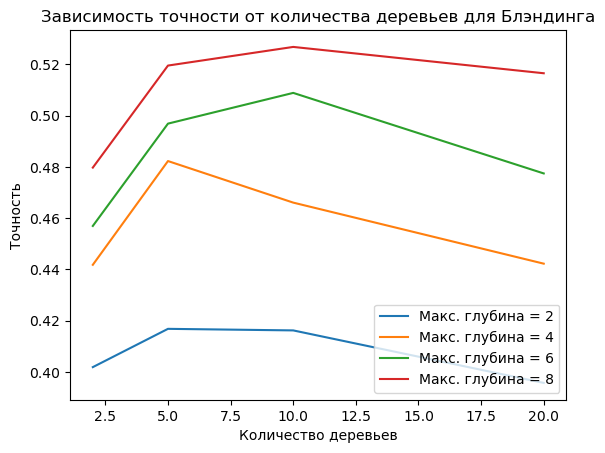

In [6]:
def make_blending_prediction(basic_clfs, final_clf, data):
    y0 = []
    for c in basic_clfs:
        y0.append(c.predict(data))
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

res = []

# Перебор всех сочетаний параметров базовых классификаторов
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        crf = []  # Список для хранения базовых классификаторов
        y_pred_1 = []  # Список для хранения предсказаний базовых классификаторов

        # Перебор количества базовых классификаторов в ансамбле (от 1 до 10)
        for n in range(1, 11):
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=n)
            clf.fit(X_train_0, y_train_0)  # Обучение базового классификатора
            crf.append(clf)  # Добавление классификатора в список
            y_pred_1.append(clf.predict(X_train_1).reshape(-1, 1))  # Предсказания базового классификатора

        # Транспонируем массив предсказаний базовых классификаторов
        y_pred_1t = np.array(y_pred_1).transpose()[0]

        # Перебор параметров финального классификатора
        for fn in n_estimators_range[-3:]:
            for fd in max_depth_range[-3:]:
                # Инициализация и обучение финального классификатора
                clf_final = RandomForestClassifier(n_estimators=fn, max_depth=fd, random_state=42)
                clf_final.fit(y_pred_1t, y_train_1)

                # Оценка финального классификатора на тестовых данных
                y_test_pred = make_blending_prediction(crf, clf_final, X_test)
                acc = metrics.accuracy_score(y_test, y_test_pred)  # Оценка точности

                res.append({
                    'base_n_estimators': n_estimators,
                    'base_max_depth': max_depth,
                    'final_n_estimators': fn,
                    'final_max_depth': fd,
                    'accuracy': acc
                })

for max_depth in max_depth_range:
    # Сбор средней точности для каждого количества деревьев при фиксированной максимальной глубине
    subset = [
        np.mean([r['accuracy'] for r in res
                if r['base_max_depth'] == max_depth and r['base_n_estimators'] == n])
        for n in n_estimators_range
    ]
    plt.plot(n_estimators_range, subset, label=f'Макс. глубина = {max_depth}')

plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.title(f'Зависимость точности от количества деревьев для Блэндинга')
plt.legend()
plt.show()

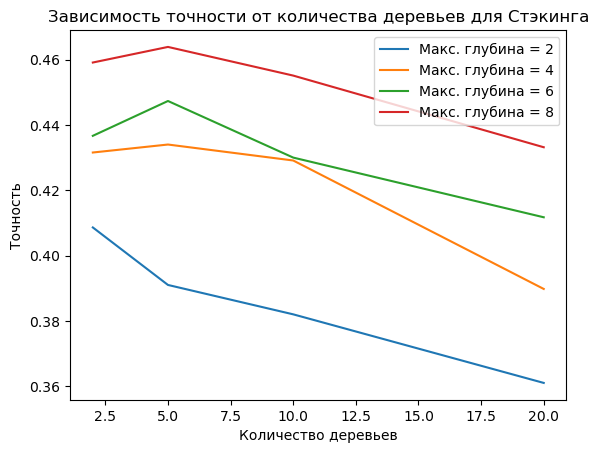

In [7]:
def make_stacking_prediction(basic_clfs, final_clf, data):
    y0 = []
    for c in basic_clfs:
        y0.append(c.predict(data))
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

from sklearn.model_selection import KFold

res = []

# KFold для кросс-валидации
kf = KFold(n_splits=10, random_state=None, shuffle=True)


for base_n_estimators in n_estimators_range:
    for base_max_depth in max_depth_range:
        # Инициализация массива для предсказаний в ходе кросс-валидации
        pre_prediction = np.zeros((len(X_train), kf.get_n_splits()))
        crf_stack = []  # Список для хранения базовых классификаторов

        # Процесс кросс-валидации
        for i, (train_index, test_index) in enumerate(kf.split(X_train)):
            X_train_0, X_test_1 = np.array(X_train)[train_index], np.array(X_train)[test_index]
            y_train_0, y_test_1 = np.array(y_train)[train_index], np.array(y_train)[test_index]

            # Обучение базового классификатора
            clf = RandomForestClassifier(n_estimators=base_n_estimators, max_depth=base_max_depth, random_state=i)
            clf.fit(X_train_0, y_train_0)
            crf_stack.append(clf)
            pre_prediction[test_index, i] = clf.predict(X_test_1)  # Сохранение предсказаний

        # Перебор параметров финального классификатора
        for final_n in n_estimators_range[-3:]:
            for fd in max_depth_range[-3:]:
                # Инициализация и обучение финального классификатора
                clf_stack_final = RandomForestClassifier(n_estimators=final_n, max_depth=fd, random_state=42)
                clf_stack_final.fit(pre_prediction, y_train)

                # Оценка модели на тестовых данных
                y_test_pred = make_stacking_prediction(crf_stack, clf_stack_final, X_test)
                acc = metrics.accuracy_score(y_test, y_test_pred)  # Оценка точности

                res.append({
                    'base_n_estimators': base_n_estimators,
                    'base_max_depth': base_max_depth,
                    'final_n_estimators': final_n,
                    'final_max_depth': fd,
                    'accuracy': acc
                })

for max_depth in max_depth_range:
    # Сбор средней точности для каждого количества деревьев при фиксированной максимальной глубине
    subset = [
        np.mean([r['accuracy'] for r in res
                if r['base_max_depth'] == max_depth and r['base_n_estimators'] == n])
        for n in n_estimators_range
    ]
    plt.plot(n_estimators_range, subset, label=f'Макс. глубина = {max_depth}')

plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.title(f'Зависимость точности от количества деревьев для Стэкинга')
plt.legend()
plt.show()

In [8]:
# Task
# criterion: “gini”, “entropy”. default=”gini”
# Задание: постройте и визуализируйте структуру решающего дерева
# для критерия разбиения “entropy"

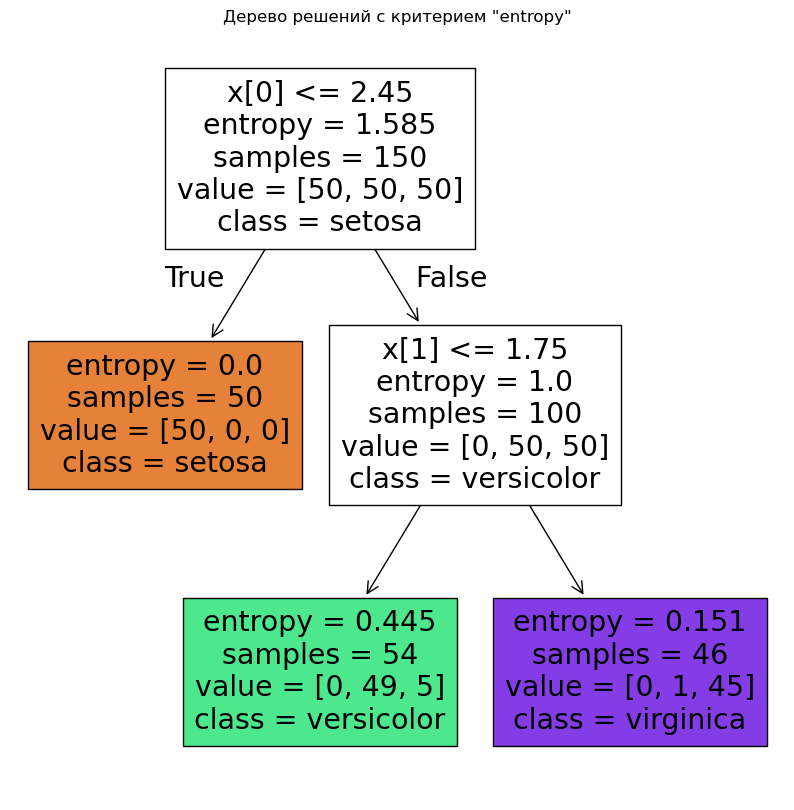

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:]  # Только два признака
y = iris.target

tree_clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
tree_clf_entropy.fit(X, y)

plt.figure(figsize=(10, 10))
tree.plot_tree(tree_clf_entropy, class_names=iris.target_names, filled=True)
plt.title('Дерево решений с критерием "entropy"')
plt.show()

In [10]:
# обучите серию классификаторов без регуляризации по минимальному количеству экземпляров в листе.
# визуализируйте MAE

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [12]:
train = pd.read_csv('train_features.csv').fillna(0)
y = pd.read_csv('train_target.csv', index_col='id')

# Удаление признака Year
train.drop('Year', axis=1, inplace=True)

real_columns = list(train.dtypes[train.dtypes != 'object'].index.values)
x_train, x_val, y_train, y_val = train_test_split(train[real_columns], y, train_size=0.8, test_size=0.2, random_state=42)

# Обучение дерева с различными значениями min_samples_leaf
min_samples_leaf_values = [1, 5, 10, 50, 100, 500, 1000]
mae_train = []
mae_val = []

for min_samples_leaf in min_samples_leaf_values:
    # Инициализация модели с данным значением min_samples_leaf
    model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(x_train, y_train)  # Обучение модели

    # Оценка модели по MAE на обучающих и валидационных данных
    mae_train.append(mean_absolute_error(y_train, model.predict(x_train)))
    mae_val.append(mean_absolute_error(y_val, model.predict(x_val)))

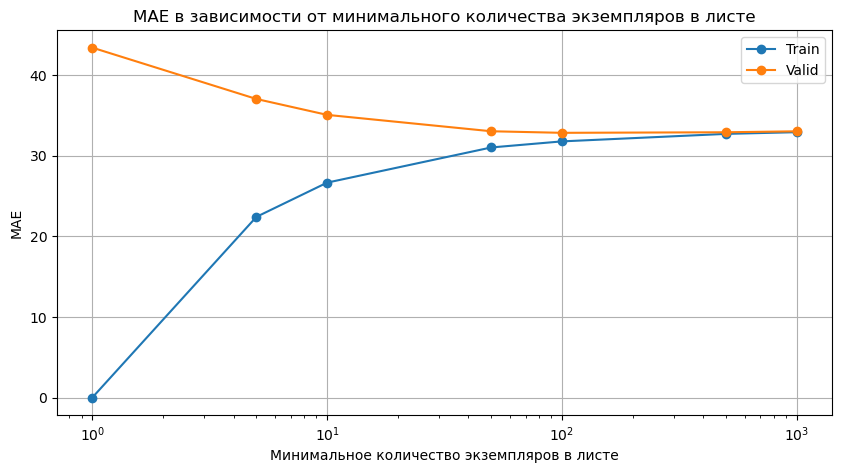

In [13]:
# Визуализация MAE
plt.figure(figsize=(10, 5))
plt.title('MAE в зависимости от минимального количества экземпляров в листе')
plt.plot(min_samples_leaf_values, mae_train, label='Train', marker='o')
plt.plot(min_samples_leaf_values, mae_val, label='Valid', marker='o')
plt.legend()
plt.xlabel('Минимальное количество экземпляров в листе')
plt.ylabel('MAE')
plt.xscale('log')  # Логарифмическая шкала для лучшего восприятия
plt.grid()
plt.show()

In [14]:
# Обучение дерева с наилучшими параметрами
best_dt = DecisionTreeRegressor(max_depth=21, min_samples_leaf=1000)
best_dt.fit(x_train[real_columns], y_train)

# Оценка MAE на валидационной выборке
mae_best = mean_absolute_error(best_dt.predict(x_val[real_columns]), y_val)
print(f'MAE на валидационной выборке с наилучшими параметрами: {mae_best}')

MAE на валидационной выборке с наилучшими параметрами: 33.02198247215921


In [16]:
# Задача: выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor
# Выбрать оптимальные параметры для каждого дерева.

In [18]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Одномерный массив
y_train_flat = y_train.values.ravel()

# Параметры для поиска
param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

# Создание модели с правильным параметром
bagging_regressor = BaggingRegressor(estimator=best_dt, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(bagging_regressor, param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_search.fit(x_train[real_columns], y_train_flat)

# Оптимальные параметры
best_params = grid_search.best_params_
best_mae = -grid_search.best_score_

print(f'Лучшие параметры: {best_params}')
print(f'Лучший MAE на валидационной выборке: {best_mae}')

Лучшие параметры: {'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 8}
Лучший MAE на валидационной выборке: 33.11377260514818
